In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-prediction/CarPrice_Assignment.csv
/kaggle/input/car-price-prediction/Data Dictionary - carprices.xlsx


# Data Preprocessing

In [2]:
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/kaggle/input/car-price-prediction/CarPrice_Assignment.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
target_feature = 'price'

In [5]:
# Extracting data dictionary for column descriptions - to be used later
data_dict = pd.read_excel('/kaggle/input/car-price-prediction/Data Dictionary - carprices.xlsx')
data_dict = data_dict.dropna(axis =1,how='all')[['Unnamed: 7','Unnamed: 11']].dropna(how = 'all')
data_dict.columns = data_dict.iloc[0]
data_dict = data_dict[1:].reset_index(drop=True)

In [6]:
# separating columns by data types
def data_by_dtypes(df):
    pd.set_option('display.max_colwidth', None)
    dataframe_dtypes = df.columns.groupby(df.dtypes)
    dtypes_list = dataframe_dtypes.keys()
    columns_count = [len(dataframe_dtypes[key]) for key in dtypes_list]
    columns = [list(dataframe_dtypes[key]) for key in dtypes_list]
    
    dtypes_details = pd.DataFrame(
        {
            'dtypes': dtypes_list,
            'columns_count': columns_count,
            'columns': columns
        }
    )
    return dtypes_details

In [7]:
data_by_dtypes(df)

,dtypes,columns_count,columns
0,int64,8,"[car_ID, symboling, curbweight, enginesize, horsepower, peakrpm, citympg, highwaympg]"
1,float64,8,"[wheelbase, carlength, carwidth, carheight, boreratio, stroke, compressionratio, price]"
2,object,10,"[CarName, fueltype, aspiration, doornumber, carbody, drivewheel, enginelocation, enginetype, cylindernumber, fuelsystem]"


In [8]:
def get_data_info(df):
    num_features = df.select_dtypes(include=[np.number])
    df_description = {
        '#' : np.arange(0,len(df.columns)),
        'feature_name' : [col for col in df.columns],
        'data type' : [df[col].dtype for col in df.columns],
        'count' : [df[col].count() for col in df.columns],
        
        'mean' : [round(df[col].mean(),2) if col in num_features else '' for col in df.columns],
        'std dev' : [round(df[col].std(),2) if col in num_features else '' for col in df.columns],
        'min' : [round(df[col].min(),2) if col in num_features else '' for col in df.columns],
        '25%' : [round(df[col].quantile(0.25),2) if col in num_features else '' for col in df.columns],
        'median' : [round(df[col].quantile(0.5),2) if col in num_features else '' for col in df.columns],
        '75%' : [round(df[col].quantile(0.75),2) if col in num_features else '' for col in df.columns],
        'max' : [round(df[col].max(),2) if col in num_features else '' for col in df.columns],
        
        'unique count' : [df[col].nunique() for col in df.columns],
        'unique values' : [list(df[col].unique()) for col in df.columns],
        
        'mode (most frequent)' : [df[col].mode()[0] for col in df.columns],
        'freq of mode' : [df[col].value_counts().max() for col in df.columns],
        'mode %' : [round(df[col].value_counts().max()*100/df.shape[0],2) for col in df.columns],
        
        'null count' : [df[col].isna().sum() for col in df.columns],
        'null %' : [round(df[col].isna().mean(),2) for col in df.columns]
    }
    
    description = pd.DataFrame(df_description)
    return description

In [9]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from textblob import TextBlob

def extract_brand(name):
    tokens = word_tokenize(name)
    tagged = pos_tag(tokens)
    # Extract the first token as the brand name
    brand = tagged[0][0]  # First token
    brand = brand.lower()
    corrected_brand = TextBlob(brand).correct().words[0]
    return brand

In [10]:
df['car_brand'] = df['CarName'].apply(lambda x: extract_brand(x))

In [11]:
data_dict

3,Car_ID,Unique id of each observation (Interger)
0,Symboling,"Its assigned insurance risk rating, A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.(Categorical)"
1,carCompany,Name of car company (Categorical)
2,fueltype,Car fuel type i.e gas or diesel (Categorical)
3,aspiration,Aspiration used in a car (Categorical)
4,doornumber,Number of doors in a car (Categorical)
5,carbody,body of car (Categorical)
6,drivewheel,type of drive wheel (Categorical)
7,enginelocation,Location of car engine (Categorical)
8,wheelbase,Weelbase of car (Numeric)
9,carlength,Length of car (Numeric)


In [12]:
df_info = get_data_info(df)
df_info

,#,feature_name,data type,count,mean,std dev,min,25%,median,75%,max,unique count,unique values,mode (most frequent),freq of mode,mode %,null count,null %
0,0,car_ID,int64,205,103.0,59.32,1,52.0,103.0,154.0,205,205,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]",1,1,0.49,0,0.0
1,1,symboling,int64,205,0.83,1.25,-2,0.0,1.0,2.0,3,6,"[3, 1, 2, 0, -1, -2]",0,67,32.68,0,0.0
2,2,CarName,object,205,,,,,,,,147,"[alfa-romero giulia, alfa-romero stelvio, alfa-romero Quadrifoglio, audi 100 ls, audi 100ls, audi fox, audi 5000, audi 4000, audi 5000s (diesel), bmw 320i, bmw x1, bmw x3, bmw z4, bmw x4, bmw x5, chevrolet impala, chevrolet monte carlo, chevrolet vega 2300, dodge rampage, dodge challenger se, dodge d200, dodge monaco (sw), dodge colt hardtop, dodge colt (sw), dodge coronet custom, dodge dart custom, dodge coronet custom (sw), honda civic, honda civic cvcc, honda accord cvcc, honda accord lx, honda civic 1500 gl, honda accord, honda civic 1300, honda prelude, honda civic (auto), isuzu MU-X, isuzu D-Max , isuzu D-Max V-Cross, jaguar xj, jaguar xf, jaguar xk, maxda rx3, maxda glc deluxe, mazda rx2 coupe, mazda rx-4, mazda glc deluxe, mazda 626, mazda glc, mazda rx-7 gs, mazda glc 4, mazda glc custom l, mazda glc custom, buick electra 225 custom, buick century luxus (sw), buick century, buick skyhawk, buick opel isuzu deluxe, buick skylark, buick century special, buick regal sport coupe (turbo), mercury cougar, mitsubishi mirage, mitsubishi lancer, mitsubishi outlander, mitsubishi g4, mitsubishi mirage g4, mitsubishi montero, mitsubishi pajero, Nissan versa, nissan gt-r, nissan rogue, nissan latio, nissan titan, nissan leaf, nissan juke, nissan note, nissan clipper, nissan nv200, nissan dayz, nissan fuga, nissan otti, nissan teana, nissan kicks, peugeot 504, peugeot 304, peugeot 504 (sw), peugeot 604sl, peugeot 505s turbo diesel, plymouth fury iii, plymouth cricket, plymouth satellite custom (sw), plymouth fury gran sedan, plymouth valiant, plymouth duster, porsche macan, porcshce panamera, porsche cayenne, porsche boxter, renault 12tl, ...]",peugeot 504,6,2.93,0,0.0
3,3,fueltype,object,205,,,,,,,,2,"[gas, diesel]",gas,185,90.24,0,0.0
4,4,aspiration,object,205,,,,,,,,2,"[std, turbo]",std,168,81.95,0,0.0
5,5,doornumber,object,205,,,,,,,,2,"[two, four]",four,115,56.10,0,0.0
6,6,carbody,object,205,,,,,,,,5,"[convertible, hatchback, sedan, wagon, hardtop]",sedan,96,46.83,0,0.0
7,7,drivewheel,object,205,,,,,,,,3,"[rwd, fwd, 4wd]",fwd,120,58.54,0,0.0
8,8,enginelocation,object,205,,,,,,,,2,"[front, rear]",front,202,98.54,0,0.0
9,9,wheelbase,float64,205,98.76,6.02,86.6,94.5,97.0,102.4,120.9,53,"[88.6, 94.5, 99.8, 99.4, 105.8, 99.5, 101.2, 103.5, 110.0, 88.4, 93.7, 103.3, 95.9, 86.6, 96.5, 94.3, 96.0, 113.0, 102.0, 93.1, 95.3, 98.8, 104.9, 106.7, 115.6, 96.6, 120.9, 112.0, 102.7, 93.0, 96.3, 95.1, 97.2, 100.4, 91.3, 99.2, 107.9, 114.2, 108.0, 89.5, 98.4, 96.1, 99.1, 93.3, 97.0, 96.9, 95.7, 102.4, 102.9, 104.5, 97.3, 104.3, 109.1]",94.5,21,10.24,0,0.0


In [13]:
def plot_avg_prices_per_cat(df,col):
    grouped_df = df.groupby(col)[target_feature].mean().reset_index()
    grouped_df.plot(kind='barh', color='skyblue')

    # Adding labels and title
    plt.ylabel(col)
    plt.xlabel(target_feature)
    plt.title('Mean of {} by {}'.format(target_feature,col))

    # Displaying the plot
    plt.show()

In [14]:
df.groupby(col)[target_feature].mean().reset_index()

NameError: name 'col' is not defined

In [15]:
# nunique_threshold = 5
# all_df_columns = df.columns
# categorical_features = [col for col in all_df_columns if df[col].nunique() < nunique_threshold]

# for col in categorical_features:
#     plot_avg_prices_per_cat(df,col)


# NOT REMOVING ANY CATEGORICAL COLUMNS FOR NOW

In [16]:
def get_categorical_features(df, nunique_threshold=20):
    all_df_columns = df.columns
    categorical_features = [col for col in all_df_columns if df[col].nunique() < nunique_threshold]
    return categorical_features

def get_numerical_features(df, nunique_threshold=20):
    numerical_df_columns = df.select_dtypes(include=[np.number]).columns
    numerical_features   = [col for col in numerical_df_columns if df[col].nunique() >= nunique_threshold]
    return numerical_features

In [17]:
categorical_features = get_categorical_features(df)
numerical_features   = get_numerical_features(df)

# Exploratory Analysis

In [18]:
print(f'categorical_features: {len(categorical_features)}\n{categorical_features}\n')
print(f'numerical_features:   {len(numerical_features)}\n{numerical_features}\n')

categorical_features: 10
['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']

numerical_features:   15
['car_ID', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']



In [19]:
import seaborn as sns
# Distribution Plots:
def my_histplot(df, col, ax):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Histogram Plot of {col}')
def my_distplot(df, col, ax):
    sns.distplot(df[col], ax=ax)
    ax.set_title(f'Distribution Plot of {col}')
def my_kdeplot(df, col, ax):
    sns.kdeplot(df[col], ax=ax, fill=True)
    ax.set_title(f'KDE Plot of {col}')
    
# Categorical Plots:
def my_pie_chart(df, col, ax):
    labels = df[col].value_counts()
    ax.pie(labels, labels=labels.index, autopct='%1.1f%%')
    ax.set_title(f'Pie Chart of {col}')
def my_countplot(df, col, ax):
    if col != 'price':
        sns.countplot(x=df[col], ax=ax)
        ax.set_title(f'Count Plot of {col}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

def my_catplot(df,col,ax):
    sns.catplot(data=df, x=col, y=target_feature, kind='box', ax=ax)

def my_boxplot(df, col, ax):
    sns.boxplot(y=df[col], ax=ax)
def my_violinplot(df, col, ax):
    sns.violinplot(y=df[col], ax=ax)
    
# Matrix Plots:
def my_heatmap(df, size, cmap, cbar_kws, font_size):
    plt.figure(figsize=size)
    sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap=cmap, center=0, cbar_kws=cbar_kws, annot_kws={"size": font_size})
    plt.title('Correlation Heatmap')
    plt.show()


In [20]:
import warnings
warnings.filterwarnings(action="ignore")
def plot_features(df, plot_funcs, width_ratios, height_ratios, n_col=1):
    def plot_feature(cols):
        n_plot_funcs = len(plot_funcs)
        fig = plt.figure(figsize=(sum(width_ratios), max(height_ratios)))
        gs = fig.add_gridspec(1, n_plot_funcs*n_col, width_ratios=width_ratios, height_ratios=height_ratios)
        axes = [0] * (n_plot_funcs * n_col)

        for i in range(n_col):
            for j in range(n_plot_funcs):
                k = i*n_plot_funcs+j
                axes[k] = fig.add_subplot(gs[0, k])
                plot_funcs[j](df, cols[i], axes[k])
                axes[k].set_xlabel(cols[i])

        plt.tight_layout()
        plt.show()
    
    for i in range(0, len(df.columns), n_col):
        plot_feature(df.columns[i:i+n_col])

In [21]:
def plot_numerical_features(df, plot_funcs=[my_boxplot, my_violinplot, my_distplot], width_ratios=[2, 2, 12], height_ratios=[4], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)
def plot_categorical_features(df, plot_funcs=[my_pie_chart, my_countplot], width_ratios=[4, 12], height_ratios=[4], n_col=1):\
    plot_features(df, plot_funcs, width_ratios, height_ratios)

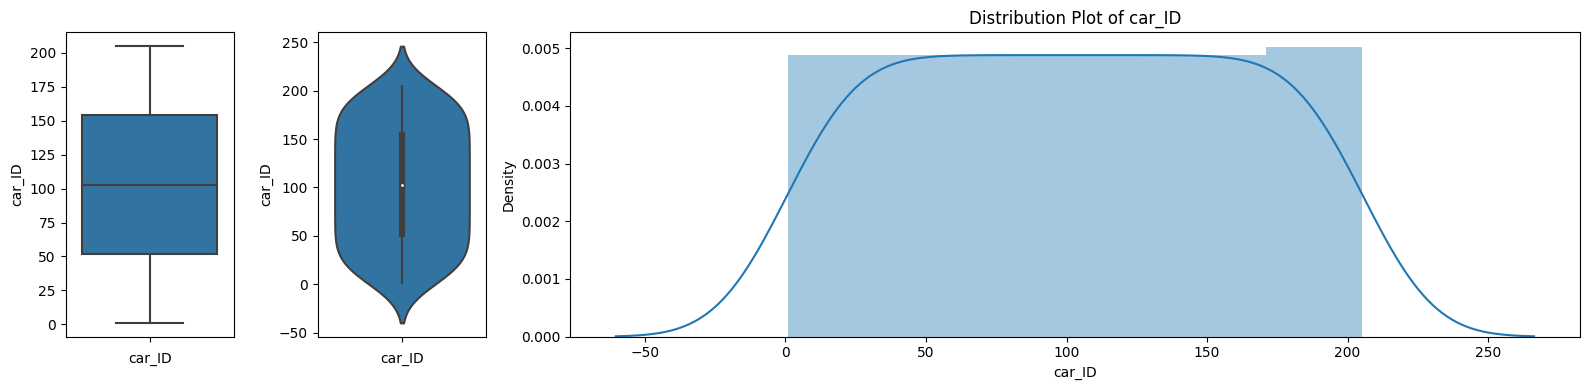

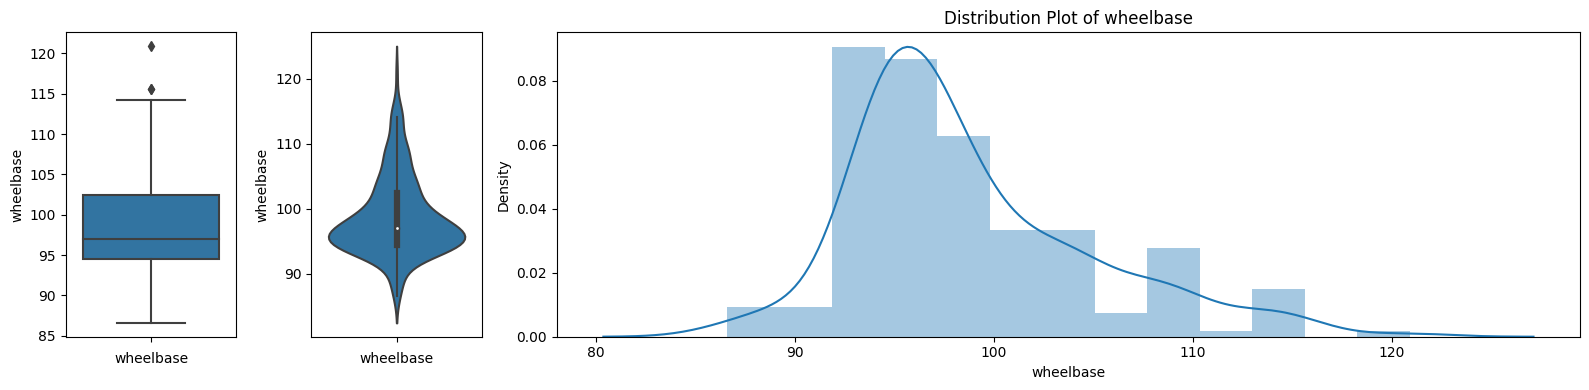

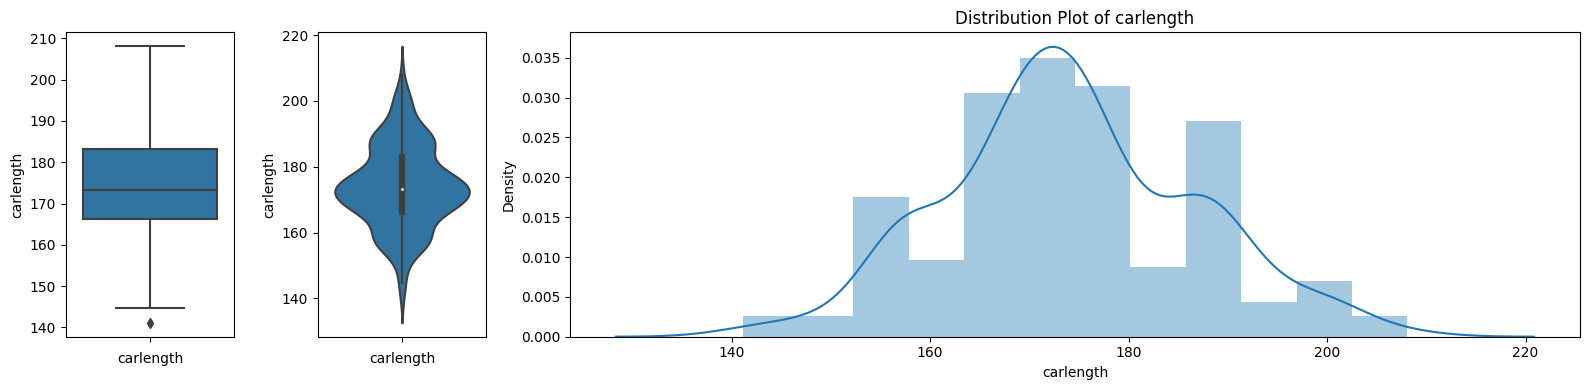

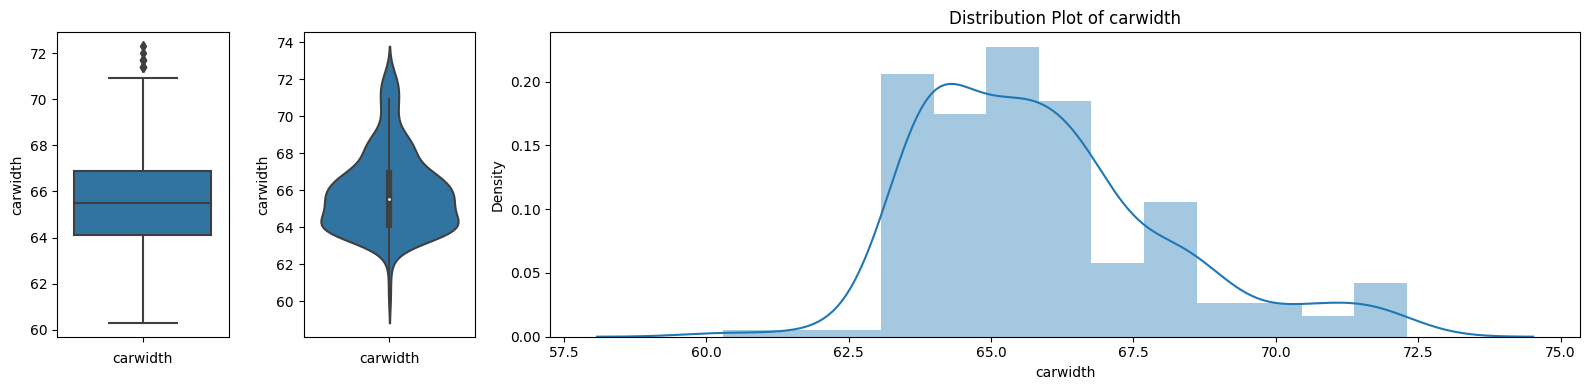

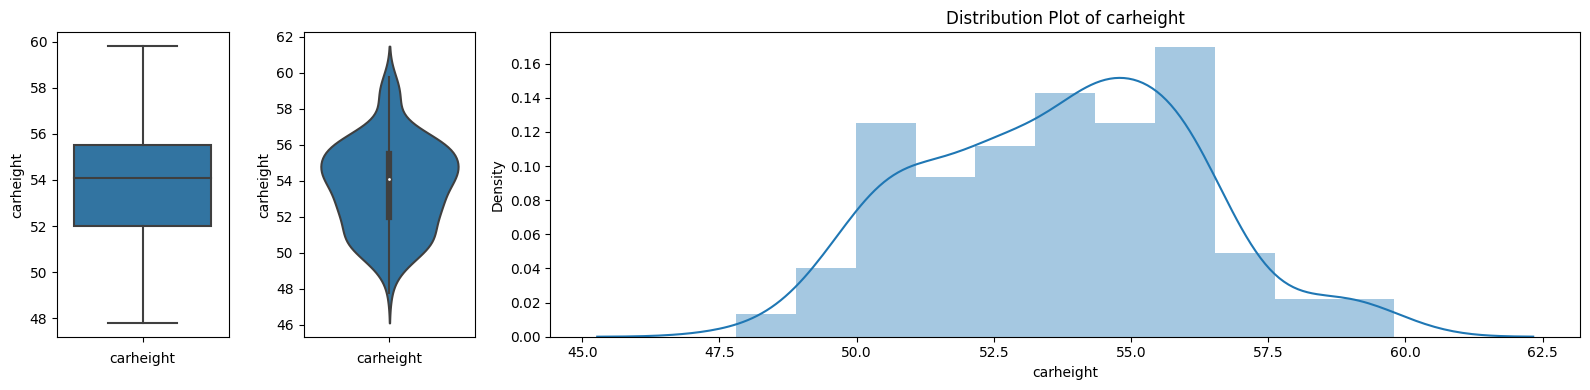

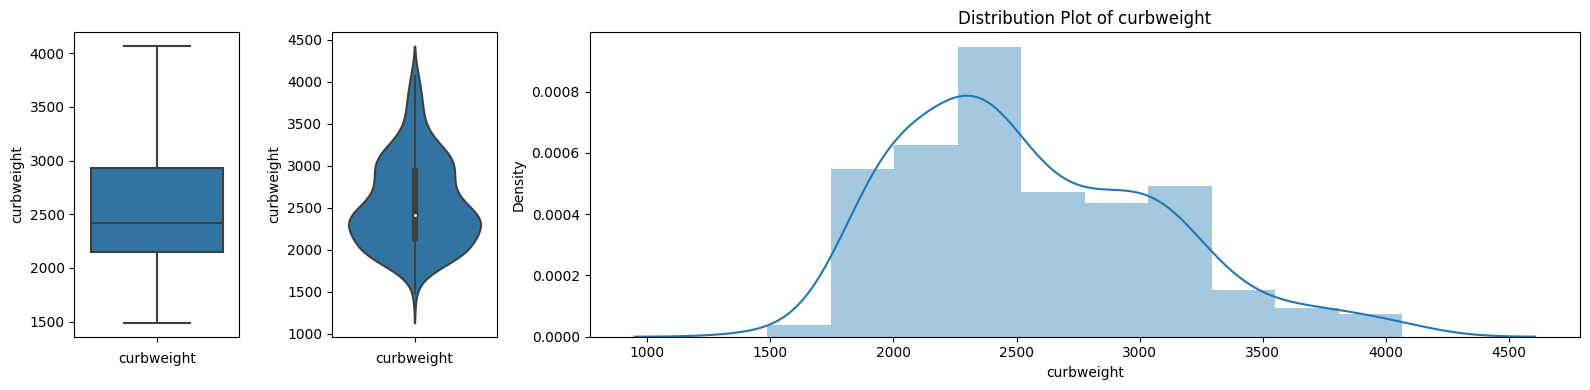

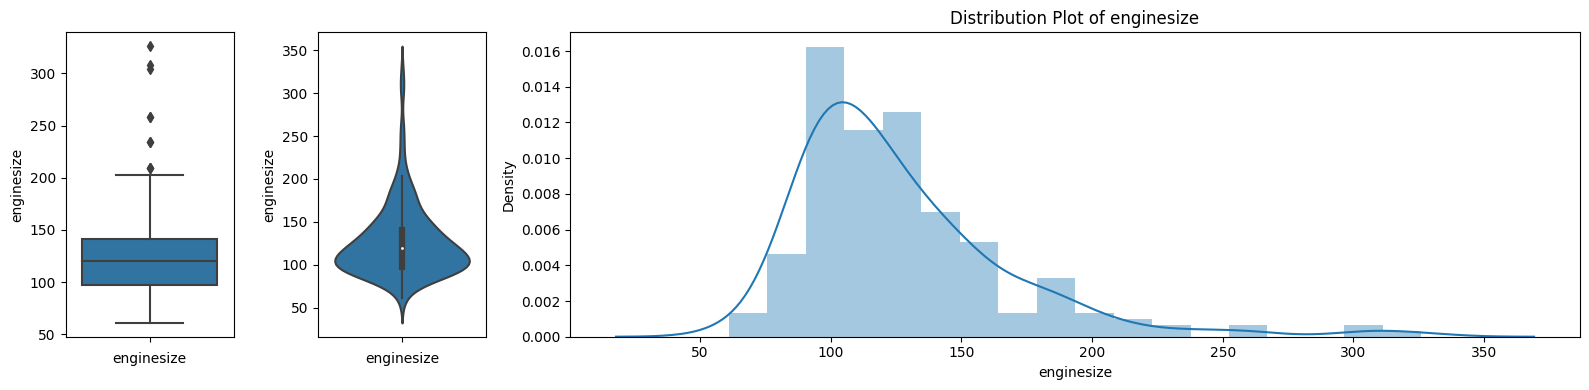

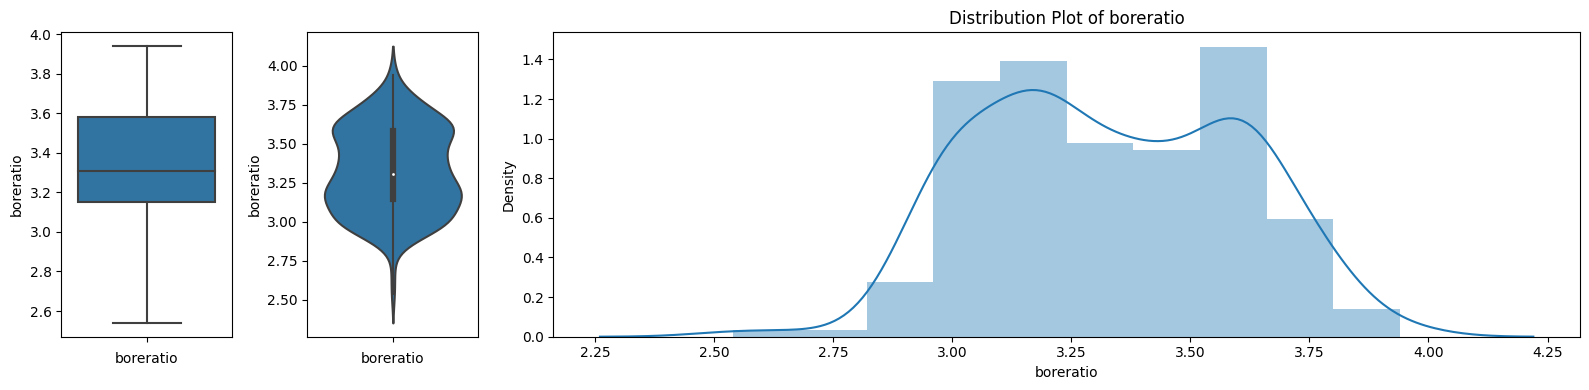

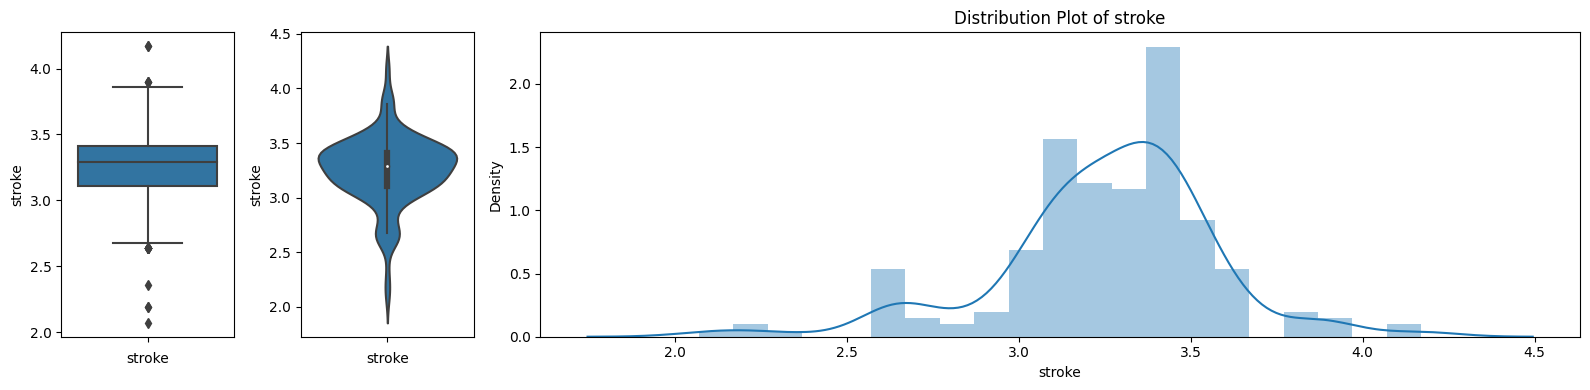

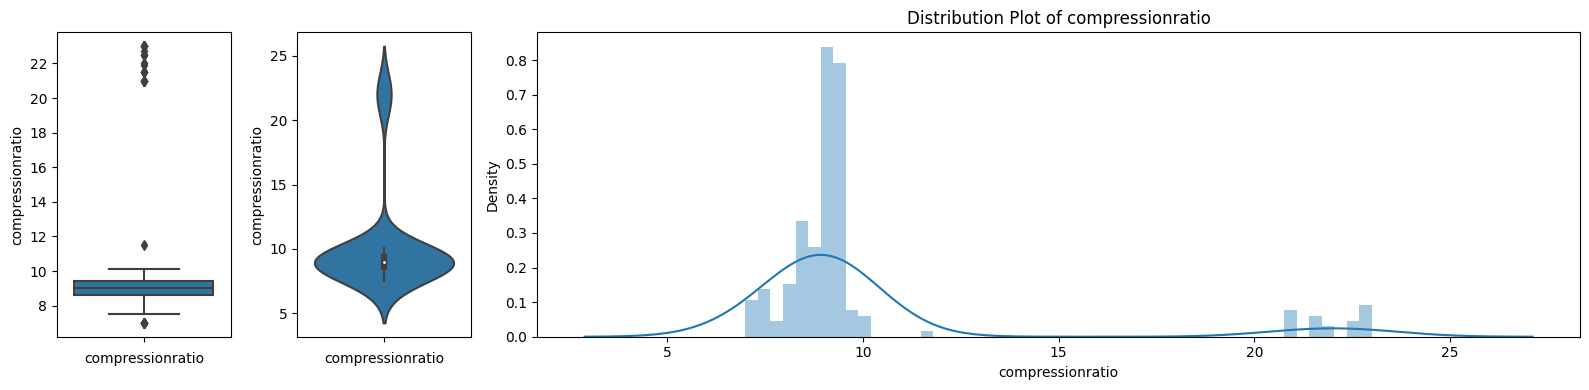

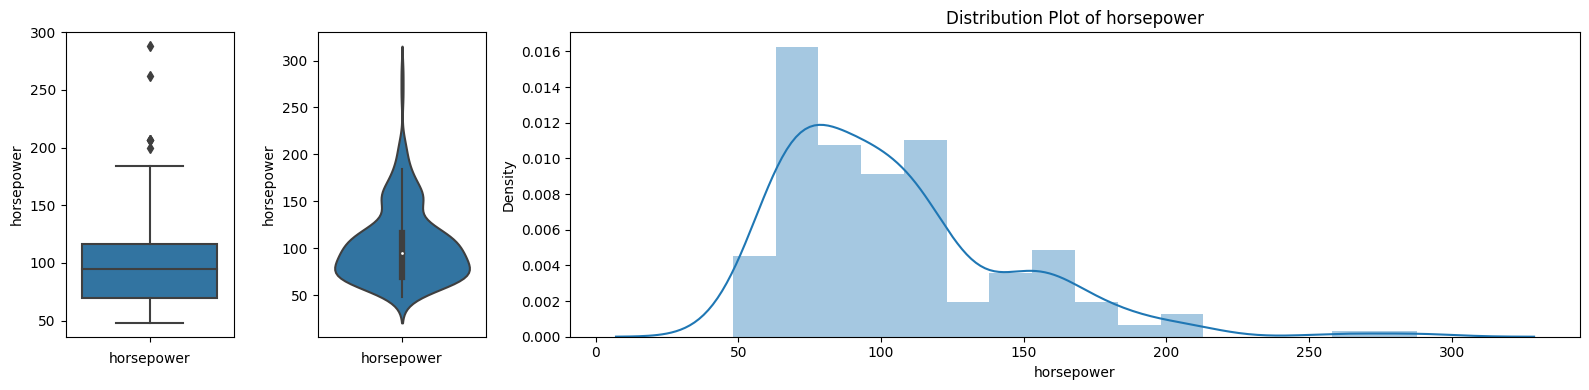

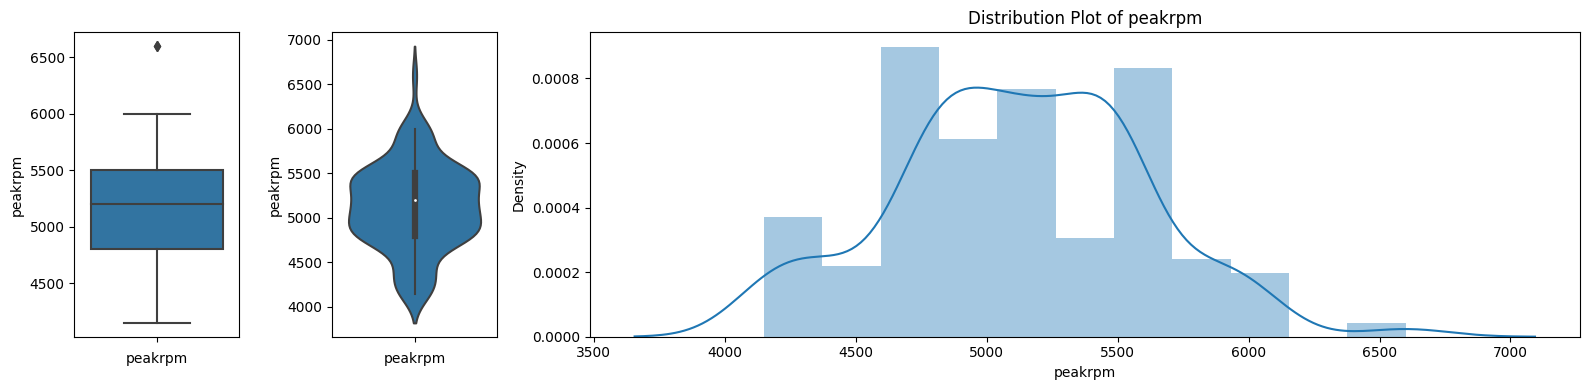

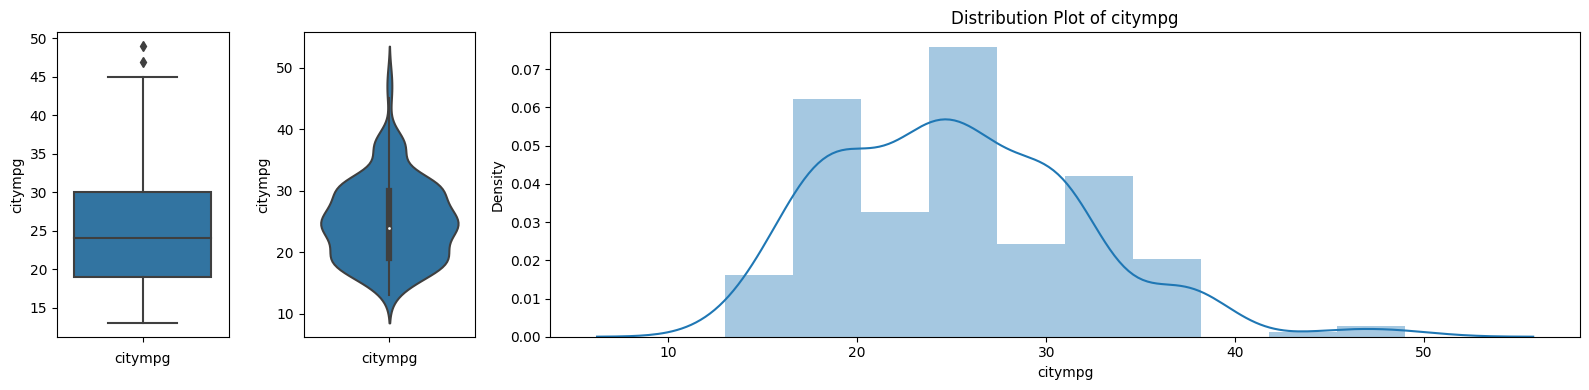

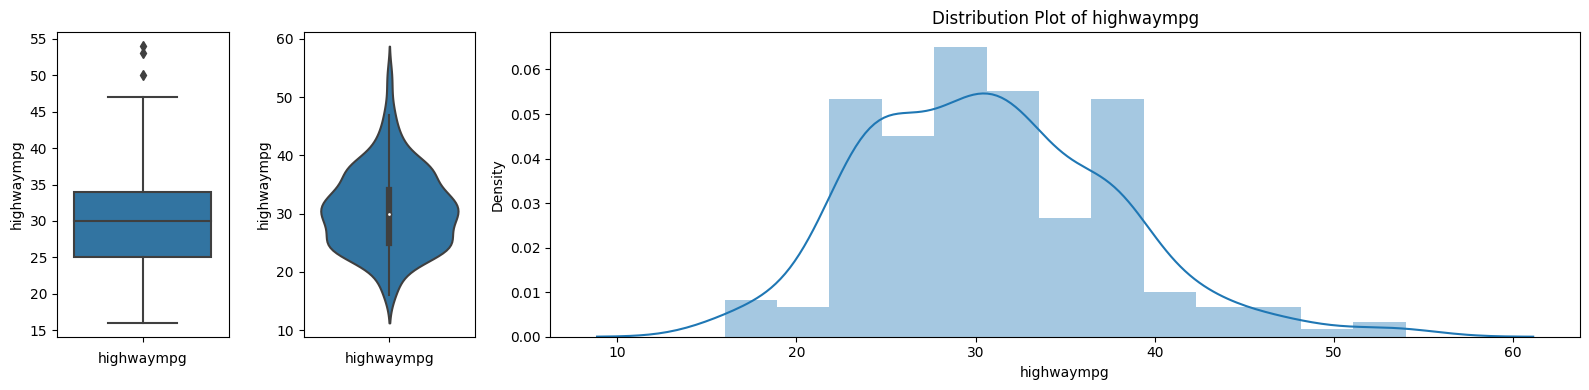

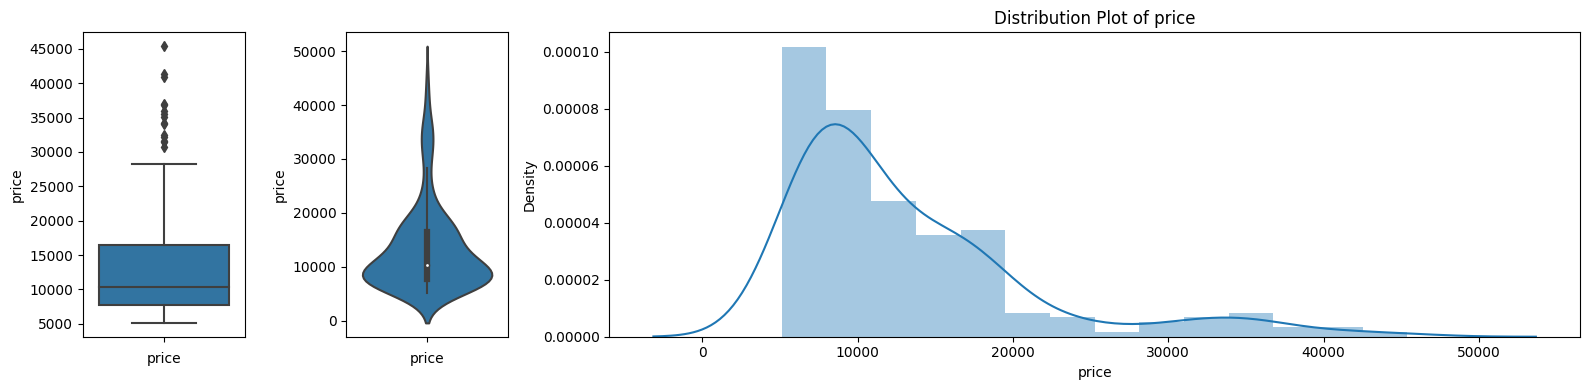

In [22]:
plot_numerical_features(df[numerical_features])

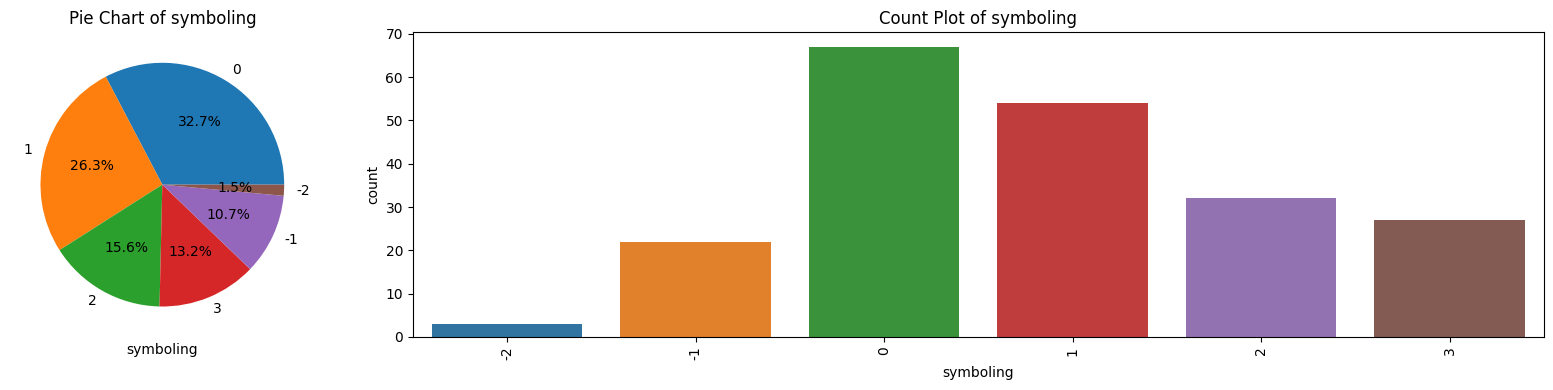

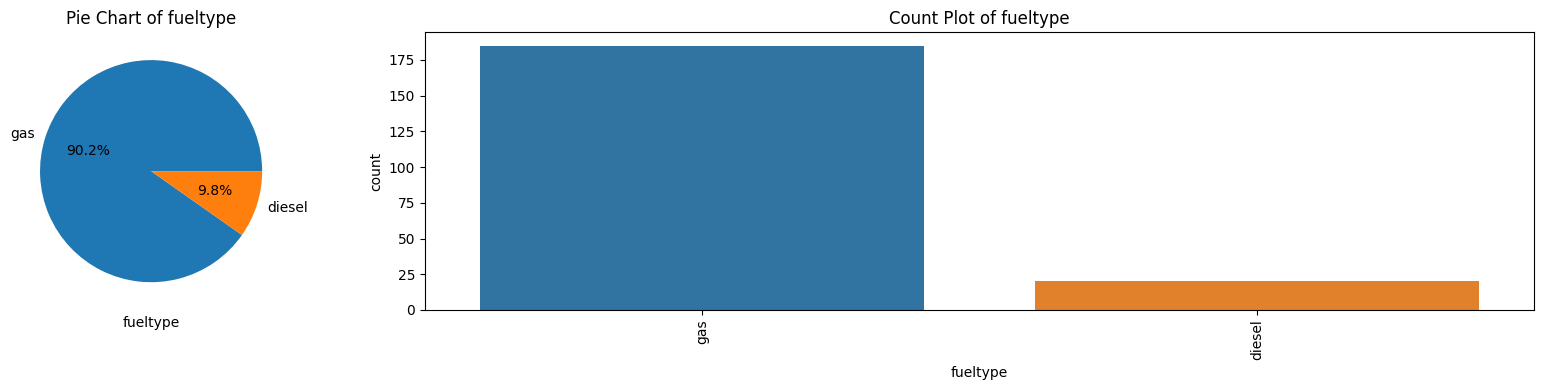

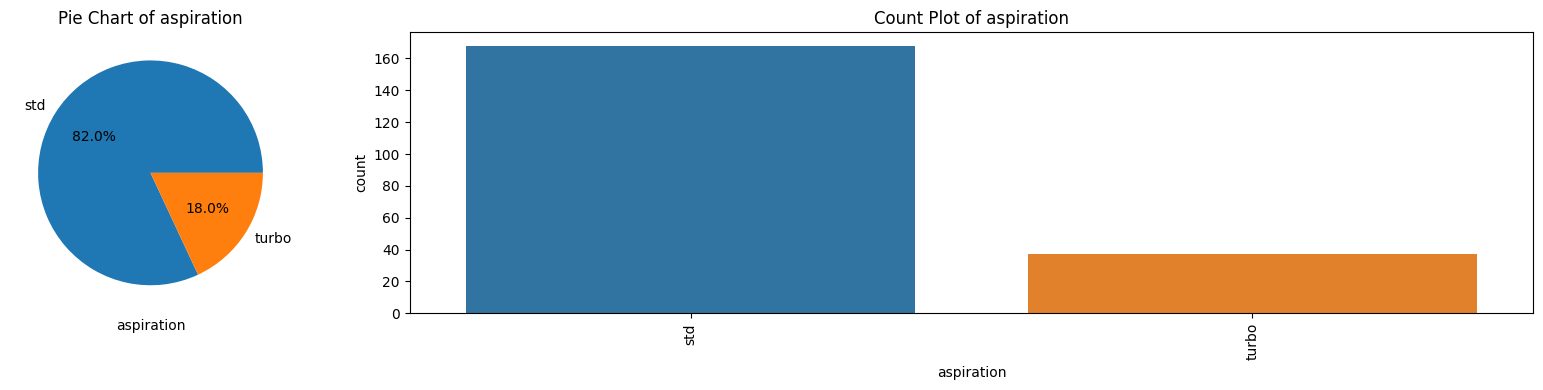

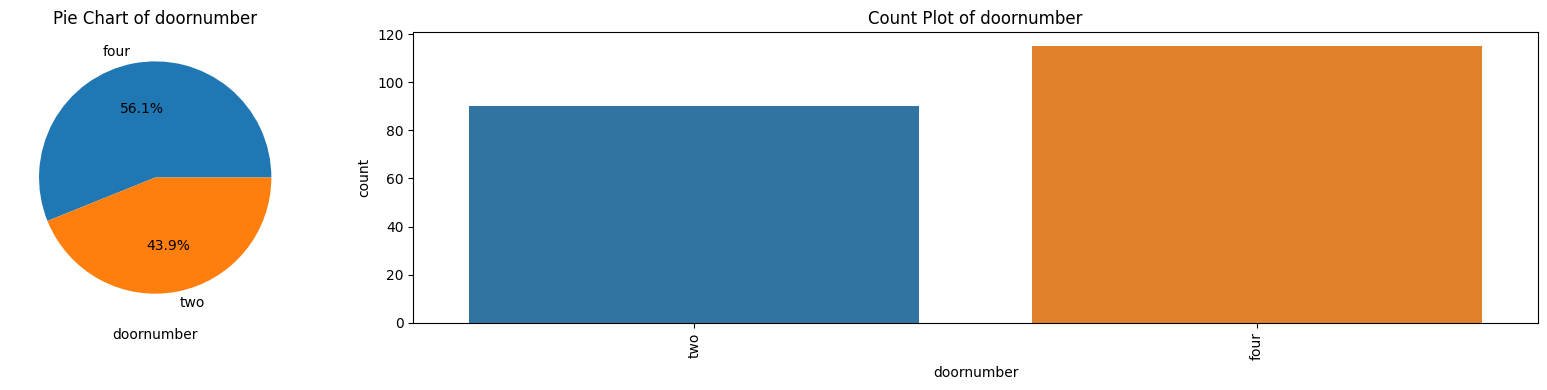

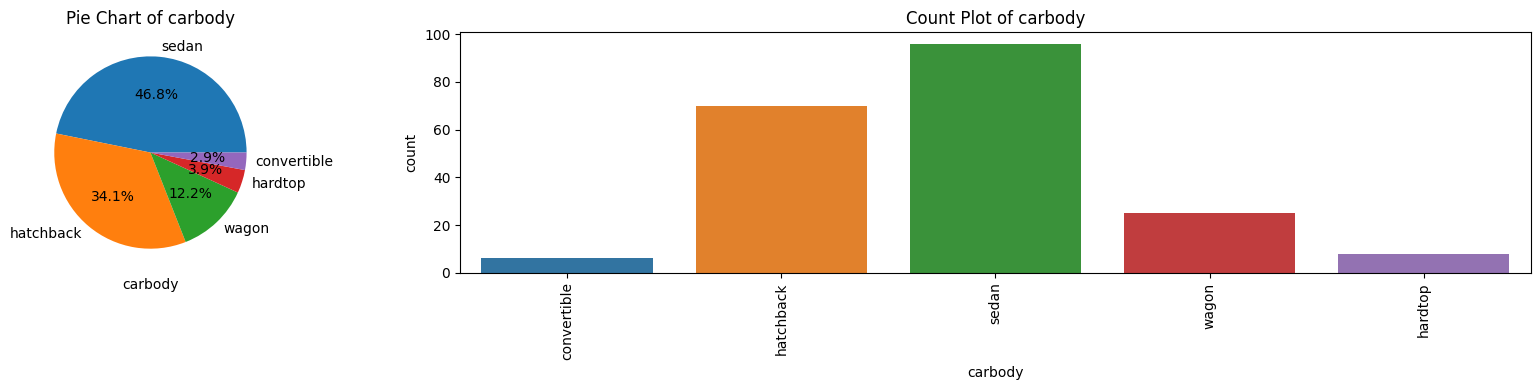

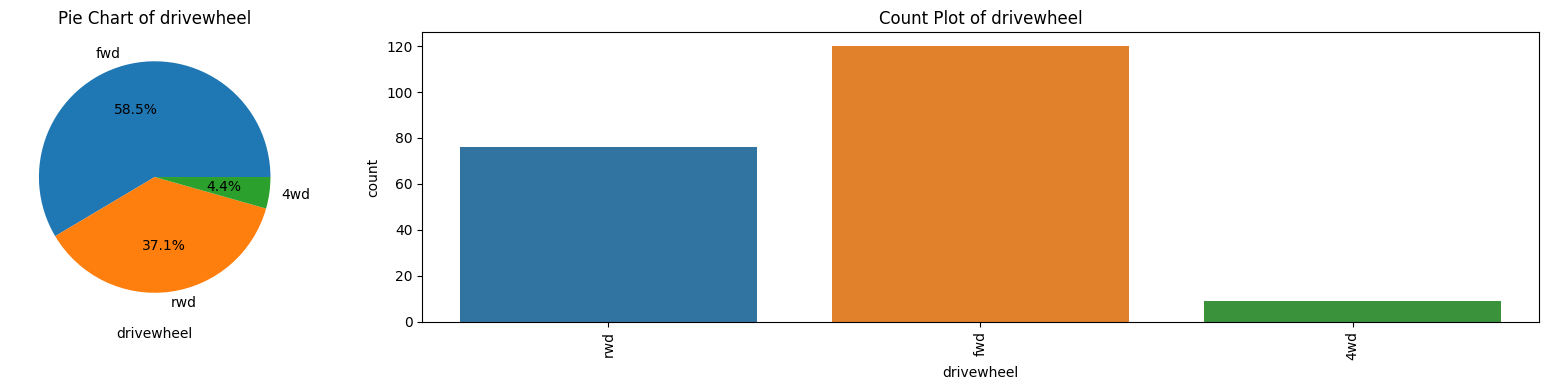

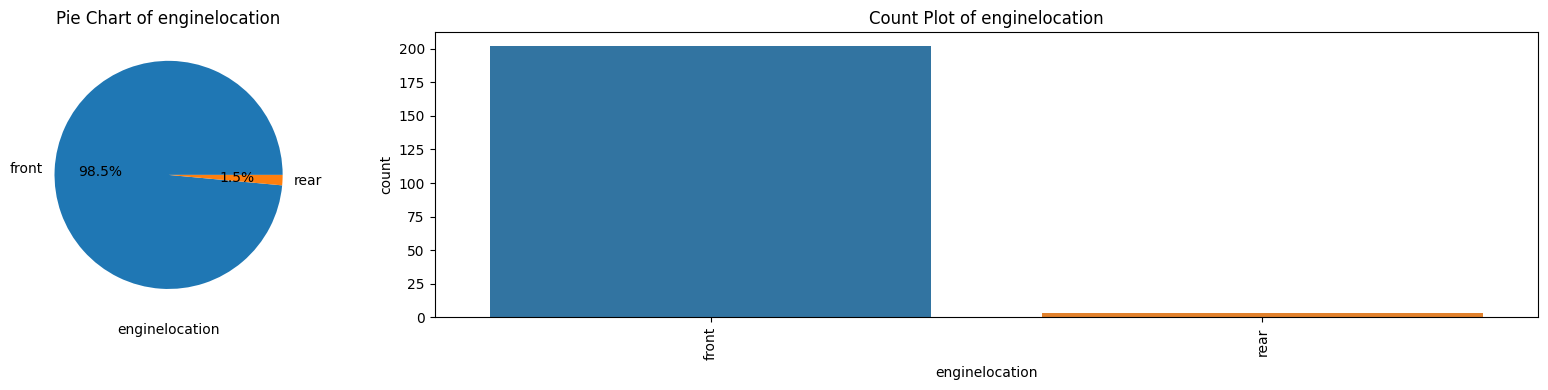

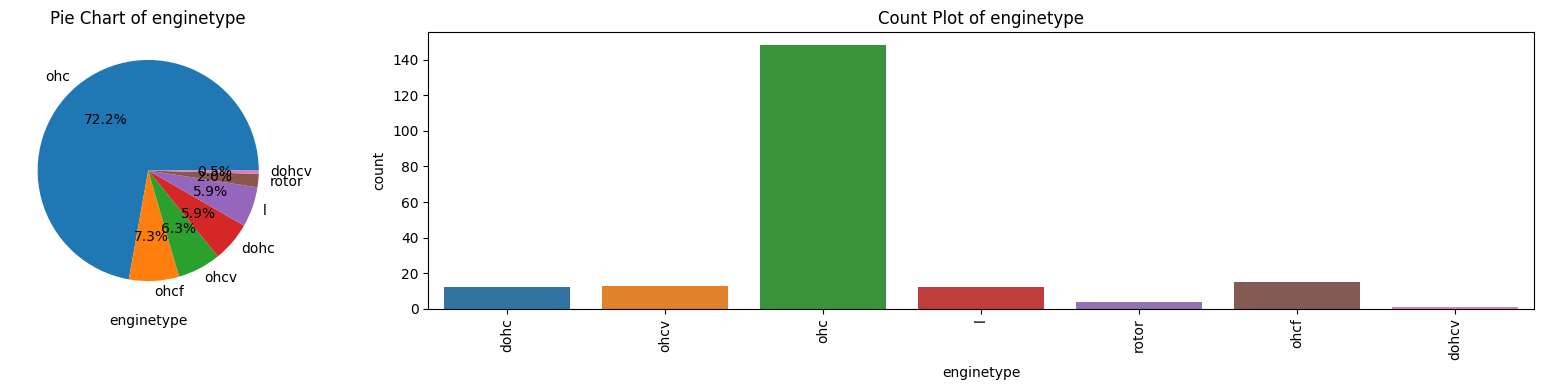

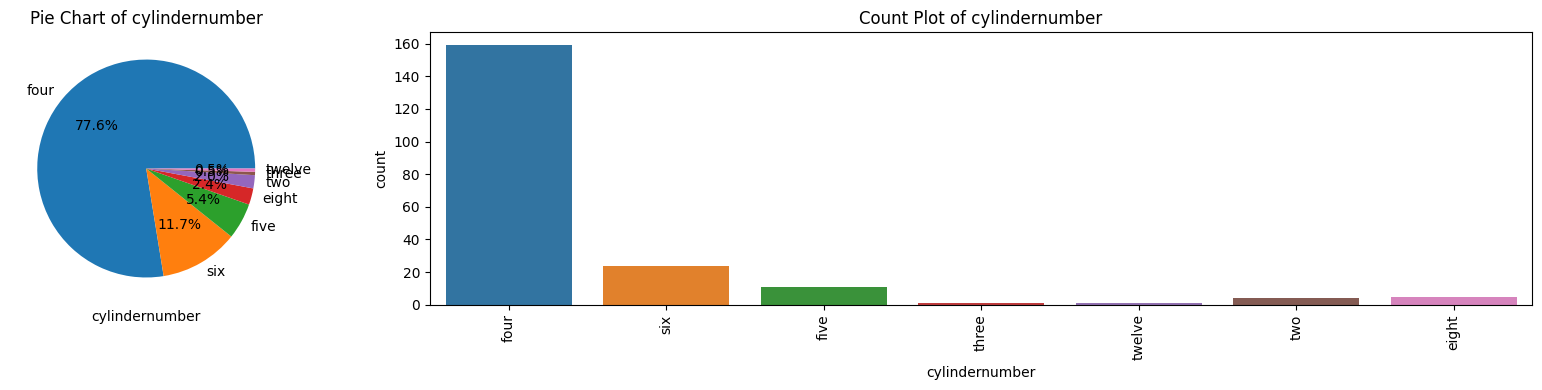

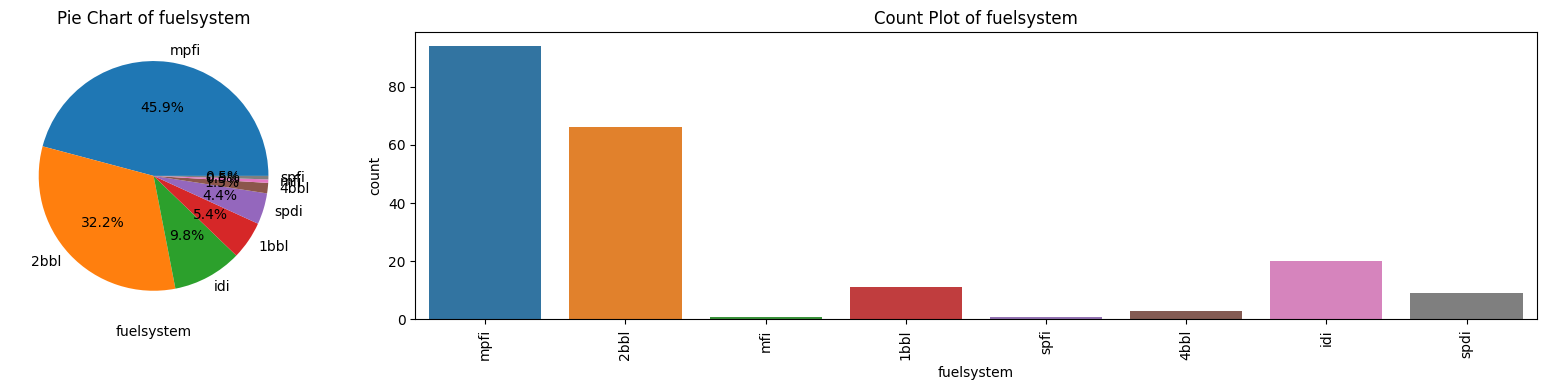

In [23]:
plot_categorical_features(df[categorical_features])

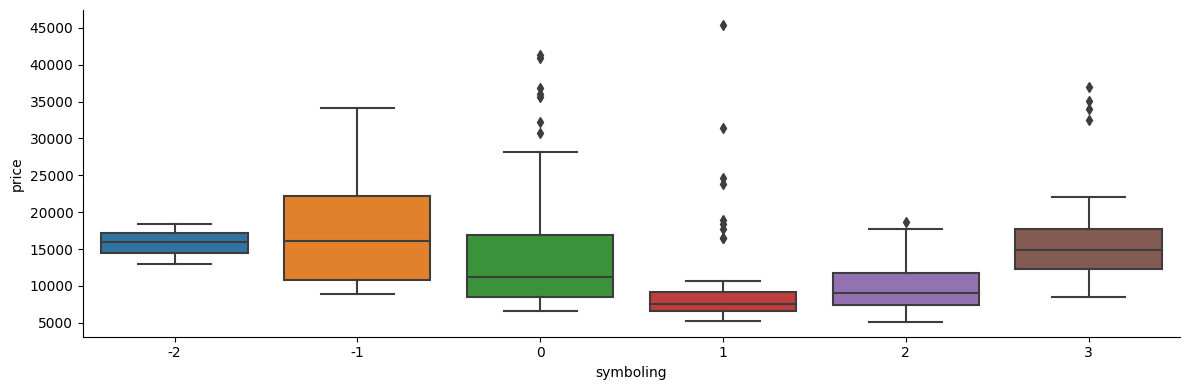

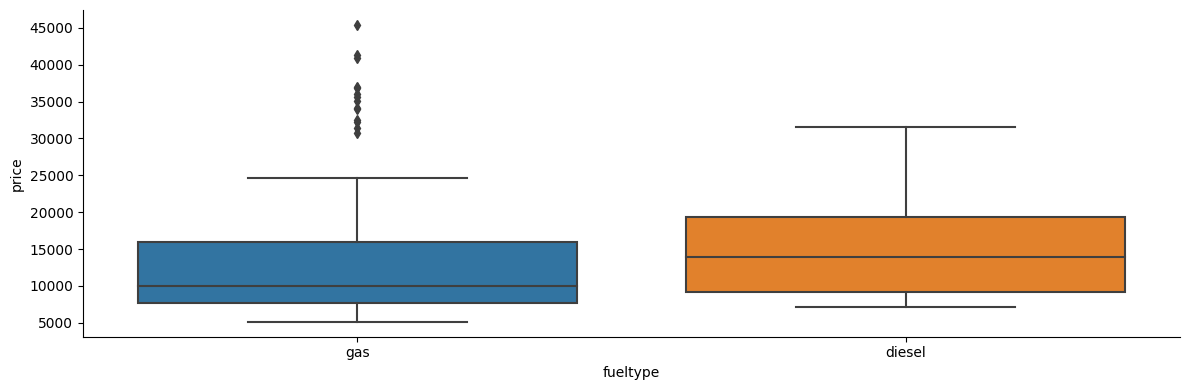

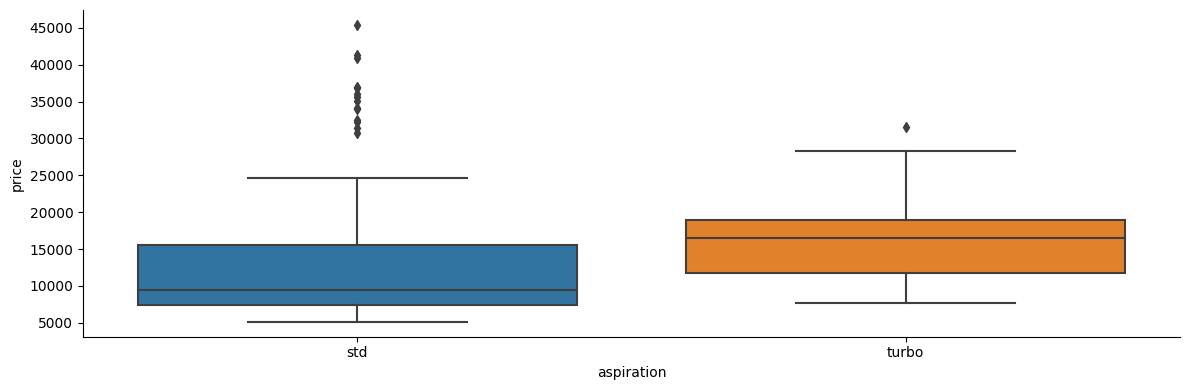

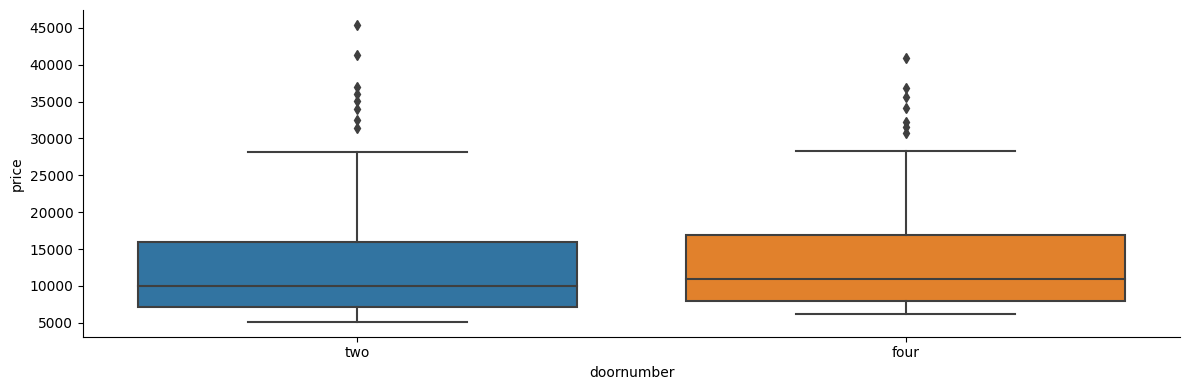

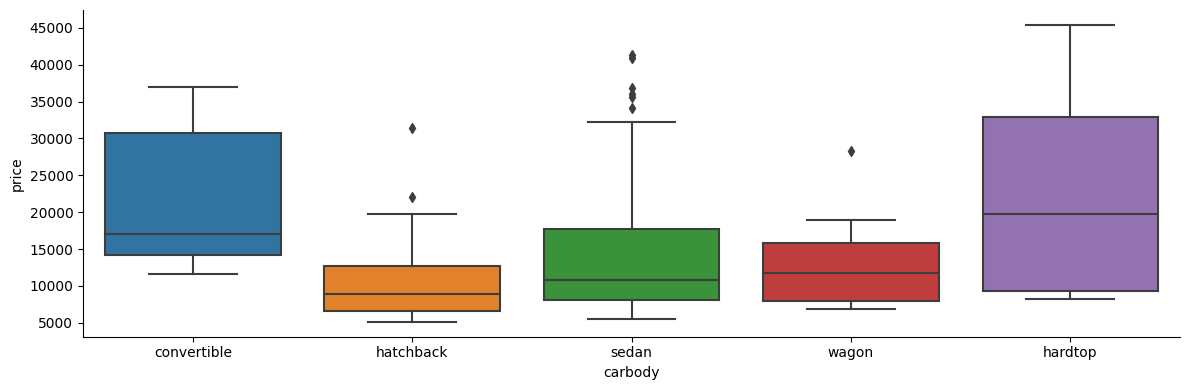

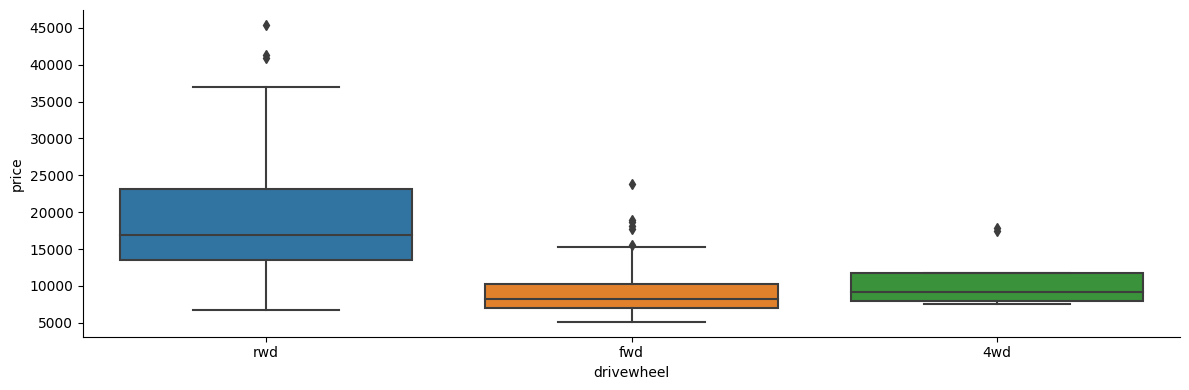

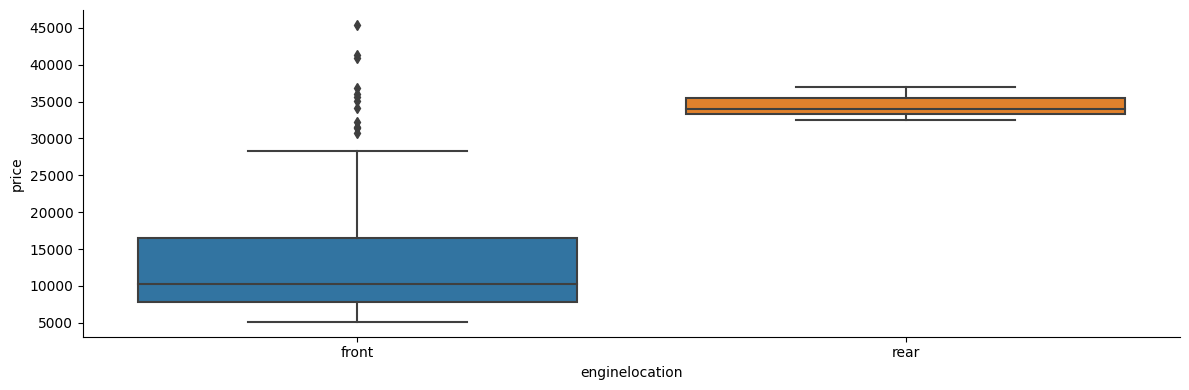

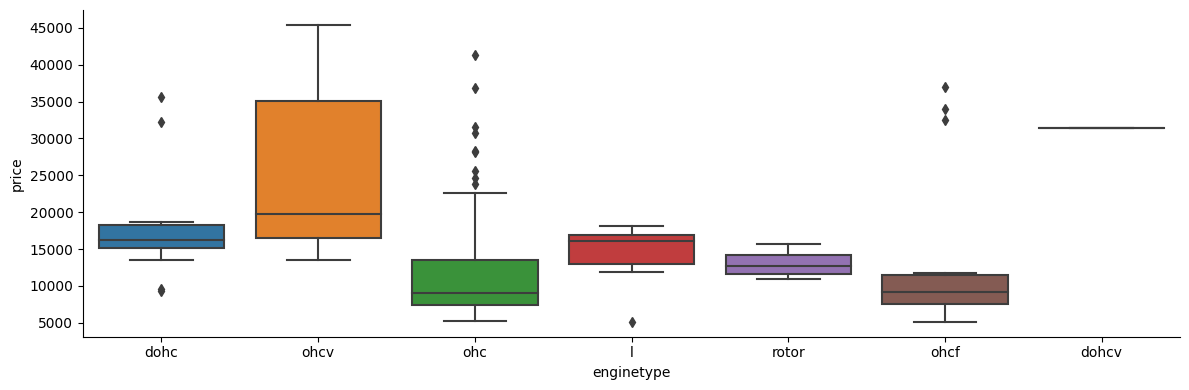

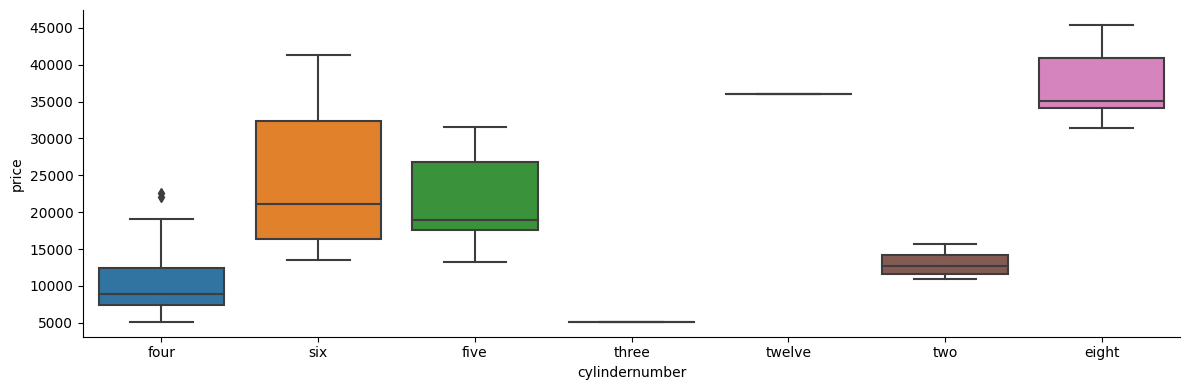

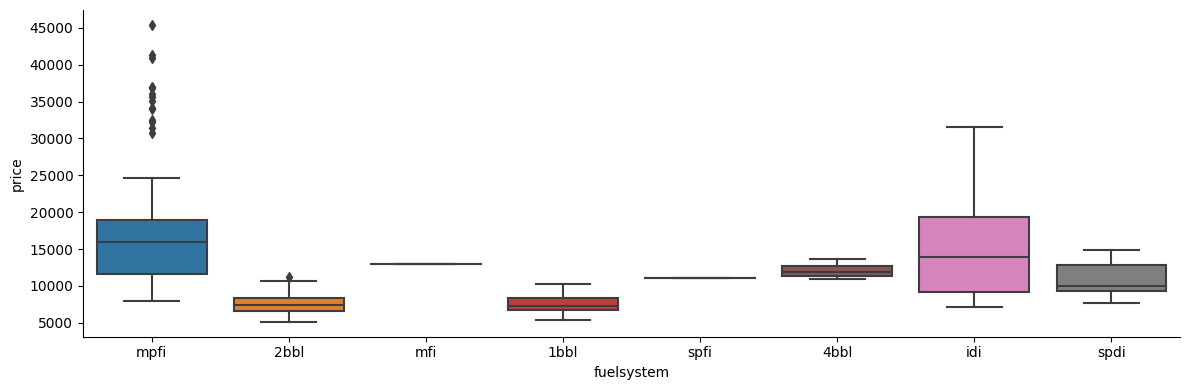

In [24]:
for category in categorical_features:
    sns.catplot(data=df, x=category, y=target_feature, kind='box', height=4, aspect=3)

In [25]:
def plot_features_correlation(df, features, target_feature, plot_kinds, step=6, height=3, aspect=1):
    df = df.sample(min(1000, df.shape[0]))
    for i in range(0, len(features), step):
        for plot_kind in plot_kinds:
            sns.pairplot(df, x_vars=features[i:i+step], y_vars=[target_feature], kind=plot_kind, height=height, aspect=aspect)

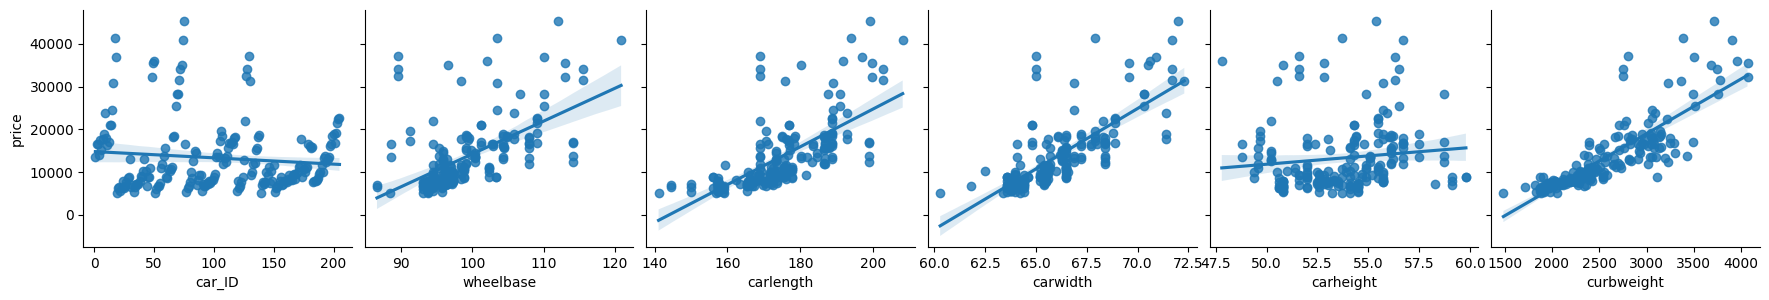

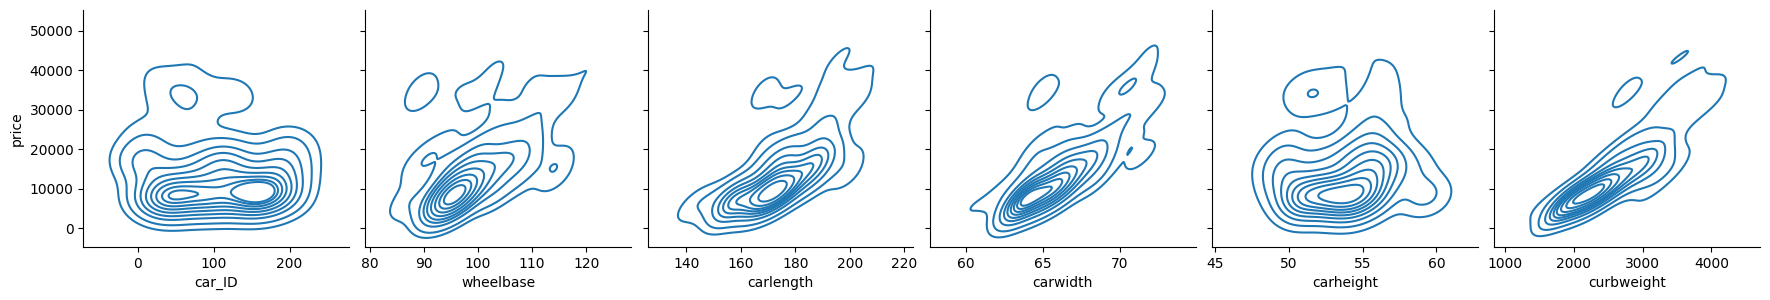

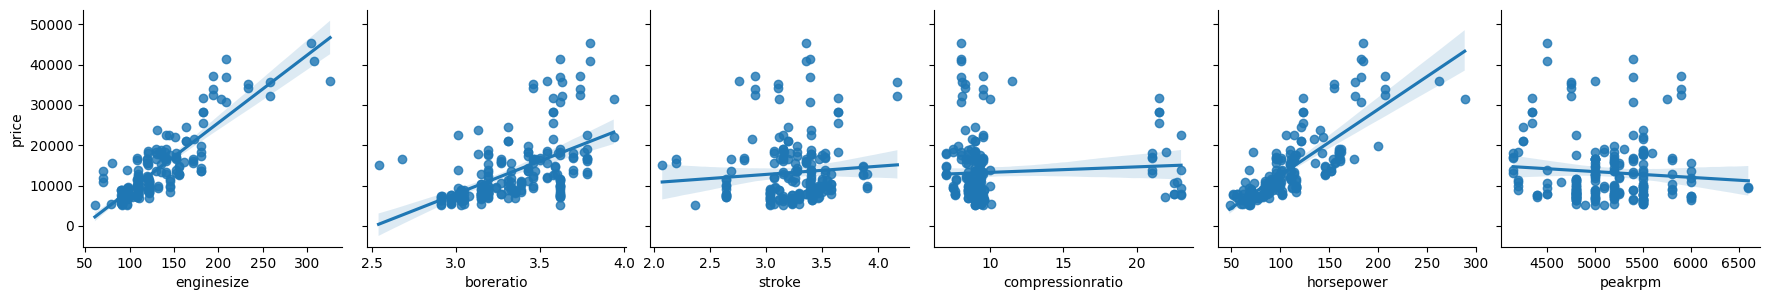

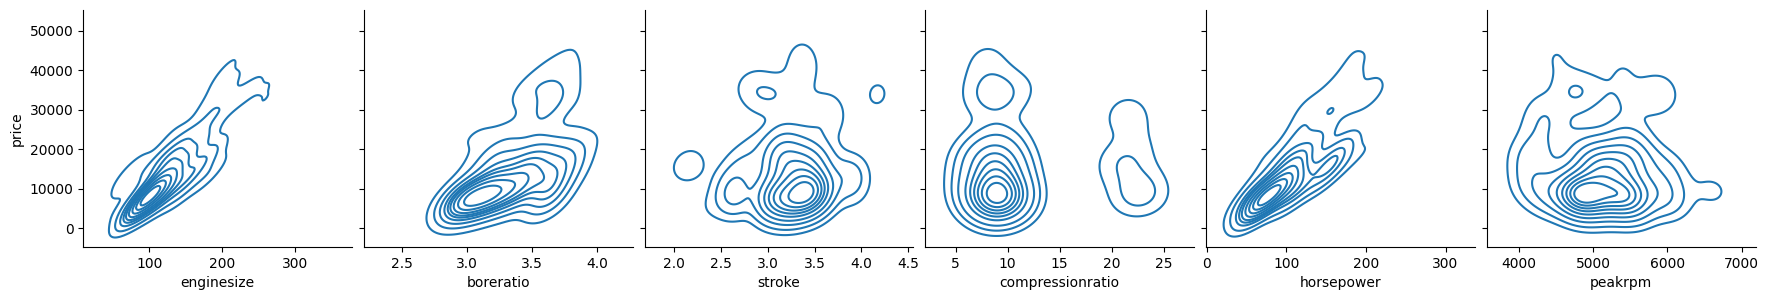

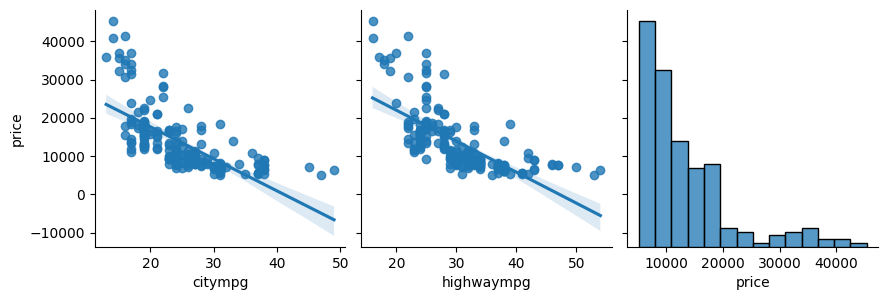

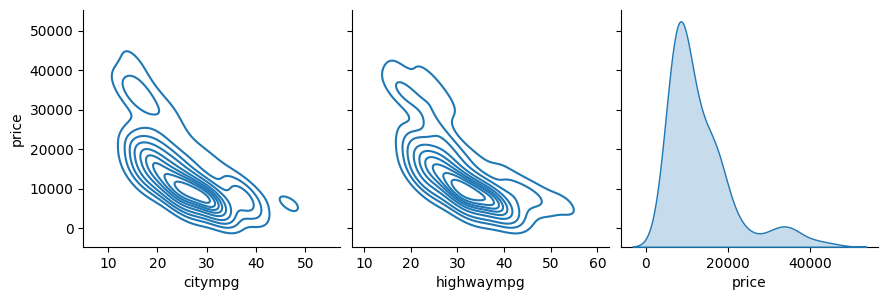

In [26]:
plot_features_correlation(df, numerical_features, target_feature, plot_kinds=['reg', 'kde'])

# Baseline Model

In [27]:
data_by_dtypes(df)

,dtypes,columns_count,columns
0,int64,8,"[car_ID, symboling, curbweight, enginesize, horsepower, peakrpm, citympg, highwaympg]"
1,float64,8,"[wheelbase, carlength, carwidth, carheight, boreratio, stroke, compressionratio, price]"
2,object,11,"[CarName, fueltype, aspiration, doornumber, carbody, drivewheel, enginelocation, enginetype, cylindernumber, fuelsystem, car_brand]"


In [28]:
def drop_id_feature(df, id_col='Id'):
    df = df.drop(columns=[id_col])
    return df

In [29]:
df = drop_id_feature(df,id_col = 'car_ID')

In [30]:
numerical_features = [col for col in numerical_features if col in df.columns and col != target_feature]

In [31]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,max_error,r2_score,explained_variance_score

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression,Ridge

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [32]:
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    me  = max_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    ev  = explained_variance_score(y_test, y_pred)

    result = {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Max Error': me,
        'R^2': r2,
        'Explained Variance': ev,
    }
    return result

In [33]:
baseline_models = {
    'LinearRegression':          LinearRegression(),
    'Ridge':                     Ridge(),
    'DecisionTreeRegressor':     DecisionTreeRegressor(),
    'KNeighborsRegressor':       KNeighborsRegressor(),
    'RandomForestRegressor':     RandomForestRegressor(),
    'SupportVectorRegressor':    SVR(),
}

In [34]:
def split_data_train_test(df, features, target_feature, test_size=0.2):
    y = df[target_feature]
    X = df[features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [35]:
features = categorical_features+numerical_features
X_train, X_test, y_train, y_test = split_data_train_test(df, features, target_feature)

In [36]:
#preprocessing pipeline for model

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler, PowerTransformer, KBinsDiscretizer, StandardScaler
from sklearn.compose import ColumnTransformer
import scipy

nominal_pipeline = make_pipeline(OneHotEncoder(drop='first', handle_unknown = 'ignore'))
numeric_pipeline = make_pipeline(PowerTransformer('yeo-johnson'),MinMaxScaler())

preprocessing_pipeline = ColumnTransformer(transformers=[
    ('nominal_pipeline',nominal_pipeline,categorical_features),
    ('numeric_pipeline',numeric_pipeline,numerical_features)
])
preprocessing_pipeline

ColumnTransformer(transformers=[('nominal_pipeline',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['symboling', 'fueltype', 'aspiration',
                                  'doornumber', 'carbody', 'drivewheel',
                                  'enginelocation', 'enginetype',
                                  'cylindernumber', 'fuelsystem']),
                                ('numeric_pipeline',
                                 Pipeline(steps=[('powertransformer',
                                                  PowerTransformer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['wheelbase', 'carlength', 'carwidth',
                                  'carheight', 'curbweight', 'enginesize',
                                  'boreratio', 'stroke', 'compressionratio',
                                  'horsepower', 'peakrpm', 'citympg',
                                  'highwaympg'])])

In [37]:
import time

def run_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        pipelined_model = make_pipeline(preprocessing_pipeline,model)
        
        print(f'Model {name} begining now ...')
        begin_time = time.time()
        pipelined_model.fit(X_train, y_train)
        y_pred = pipelined_model.predict(X_test)
        results[name] = evaluate_model(y_test, y_pred)
        end_time = time.time()
        duration = round((end_time - begin_time) / 60, 2)
        print(f'Model {name} run in'.ljust(50), f'{duration} minutes')
    results = pd.DataFrame(results).T
    results = results.reset_index()
    return results

In [38]:
models_result1 = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression begining now ...
Model LinearRegression run in                      0.0 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.0 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.0 minutes
Model KNeighborsRegressor begining now ...
Model KNeighborsRegressor run in                   0.0 minutes
Model RandomForestRegressor begining now ...
Model RandomForestRegressor run in                 0.01 minutes
Model SupportVectorRegressor begining now ...
Model SupportVectorRegressor run in                0.0 minutes


In [39]:
models_result1

,index,Mean Absolute Error,Mean Squared Error,Max Error,R^2,Explained Variance
0,LinearRegression,2539.706219,1.503056e+07,13308.801527,0.809605,0.809643
1,Ridge,2869.601956,1.704838e+07,14927.306495,0.784045,0.784928
2,DecisionTreeRegressor,1869.056902,7.581888e+06,8348.000000,0.903959,0.906912
3,KNeighborsRegressor,2692.099195,1.529315e+07,11964.000000,0.806279,0.809385
4,RandomForestRegressor,1263.645831,3.382890e+06,5465.860000,0.957148,0.958105
5,SupportVectorRegressor,5699.002437,8.681285e+07,30641.701885,-0.099676,0.002176


In [40]:
def plot_models_results(results, metric):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results, x='index', y=metric)

    plt.title(f"Model Comparison using {metric}")
    plt.xlabel("Model")
    plt.ylabel(metric)

    yminlim = results[metric].min()
    ymaxlim = results[metric].max()
    yrange = (ymaxlim - yminlim) * .1
    yminlim -= yrange
    ymaxlim += yrange
    plt.ylim(yminlim, ymaxlim)
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()

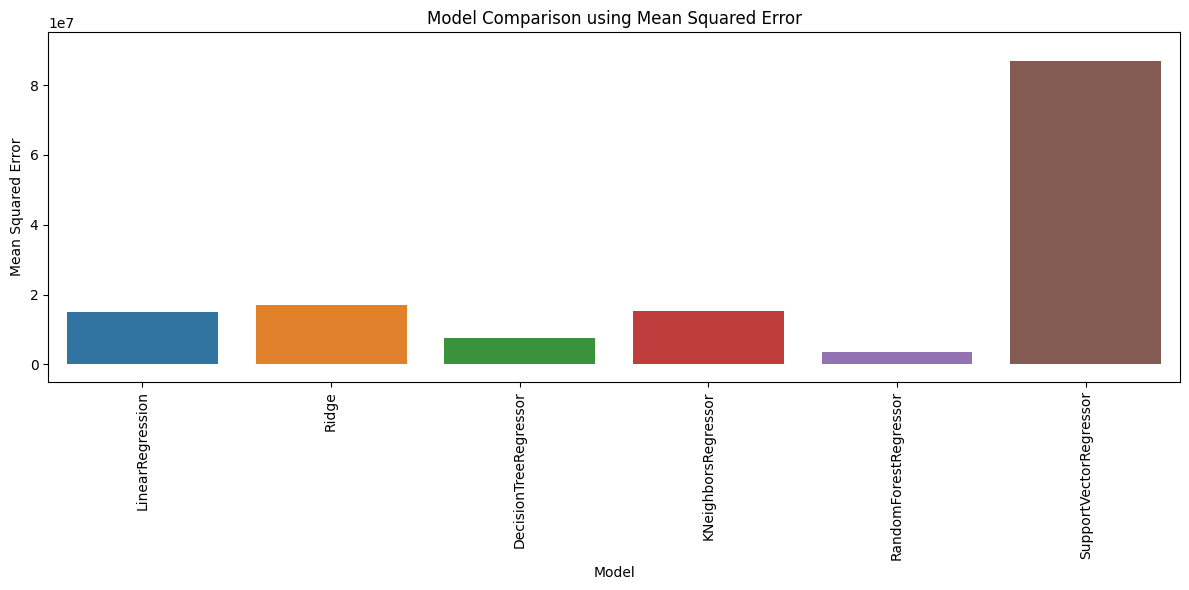

In [41]:
plot_models_results(models_result1, 'Mean Squared Error')

In [42]:
def get_best_model(results_df, models, metric):
    best_model_name = results_df.sort_values(by=[metric]).head(1)['index'].iloc[0]
    best_model = models[best_model_name]
    return best_model

In [43]:
best_models1 = get_best_model(models_result1, baseline_models, 'Mean Squared Error')
print('Best Model of Baseline Models is:', best_models1.__class__.__name__)

Best Model of Baseline Models is: RandomForestRegressor


# Feature Engineering

In [44]:
df = df[features]

In [45]:
def get_skewed_features(df, skewed_threshold=0.75):
    numerical_features = get_numerical_features(df)
    skewed = df[numerical_features].apply(lambda x: x.skew())
    skewed = skewed.sort_values(ascending=False)
    skewed = skewed.reset_index()
    skewed.columns = ['Feature', 'Skew']
    skewed_features = list(skewed[abs(skewed['Skew']) > skewed_threshold]['Feature'])
    non_skewed_features = list(set(numerical_features)-set(skewed_features))
    return skewed_features, non_skewed_features

In [46]:
skewed_features, non_skewed_features = get_skewed_features(X_train)

In [47]:
skewed_features
# These have already been takan care of with the preprocessing pipeline

['compressionratio',
 'enginesize',
 'horsepower',
 'carwidth',
 'wheelbase',
 'stroke']

In [48]:
from sklearn.feature_selection import mutual_info_regression

def feature_selection(X, y, mutual_info_method, importance_threshold=0.1):
    mutual_info = mutual_info_method(X, y)
    features_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': mutual_info
    })
    features_importance = features_importance.sort_values(by='Importance', ascending=False)
    features_importance = features_importance[features_importance['Importance'] > importance_threshold]
    return features_importance

In [49]:
model = RandomForestRegressor()
pipelined_model = make_pipeline(preprocessing_pipeline,model)
pipelined_model.fit(X_train, y_train)

X_transformed = pipelined_model.named_steps['columntransformer'].transform(X_train)
mi_scores = mutual_info_regression(X_transformed, y_train)

print(mi_scores)

[0.04558702 0.07502603 0.08524293 0.01471296 0.0357957  0.
 0.05306483 0.03769481 0.         0.07569507 0.03359025 0.00219754
 0.30675922 0.31056836 0.         0.         0.07335754 0.14387481
 0.00547707 0.06041307 0.         0.03847915 0.26173061 0.12647378
 0.         0.         0.35709283 0.         0.         0.
 0.29728347 0.01257433 0.         0.55176384 0.59984498 0.62094212
 0.25138877 0.91730017 0.79457081 0.44685121 0.32447103 0.23515377
 0.81065499 0.24511663 0.79192767 0.81393279]


In [50]:
# Extract the names of the original features
cat_features = preprocessing_pipeline.named_transformers_['nominal_pipeline'].get_feature_names_out(categorical_features)

# Combine the feature names
feature_names = list(cat_features) + numerical_features

In [59]:
feature_names
features_importance = pd.DataFrame({'Feature': feature_names, 'MI Score': mi_scores})

def plot_features_importance(features_importance, size=(12, 8)):
    feature_importance_sorted = features_importance.sort_values(by='MI Score', ascending=False)
    size=(12, features_importance.shape[0]//12*4+2)
    plt.figure(figsize=size)
    barplot=sns.barplot(x='MI Score', y='Feature', data=feature_importance_sorted, palette='viridis')
    plt.xlabel('Importance Contribution (%)')
    plt.title('Importance Contribution of Selected Features')

    
    plt.show()

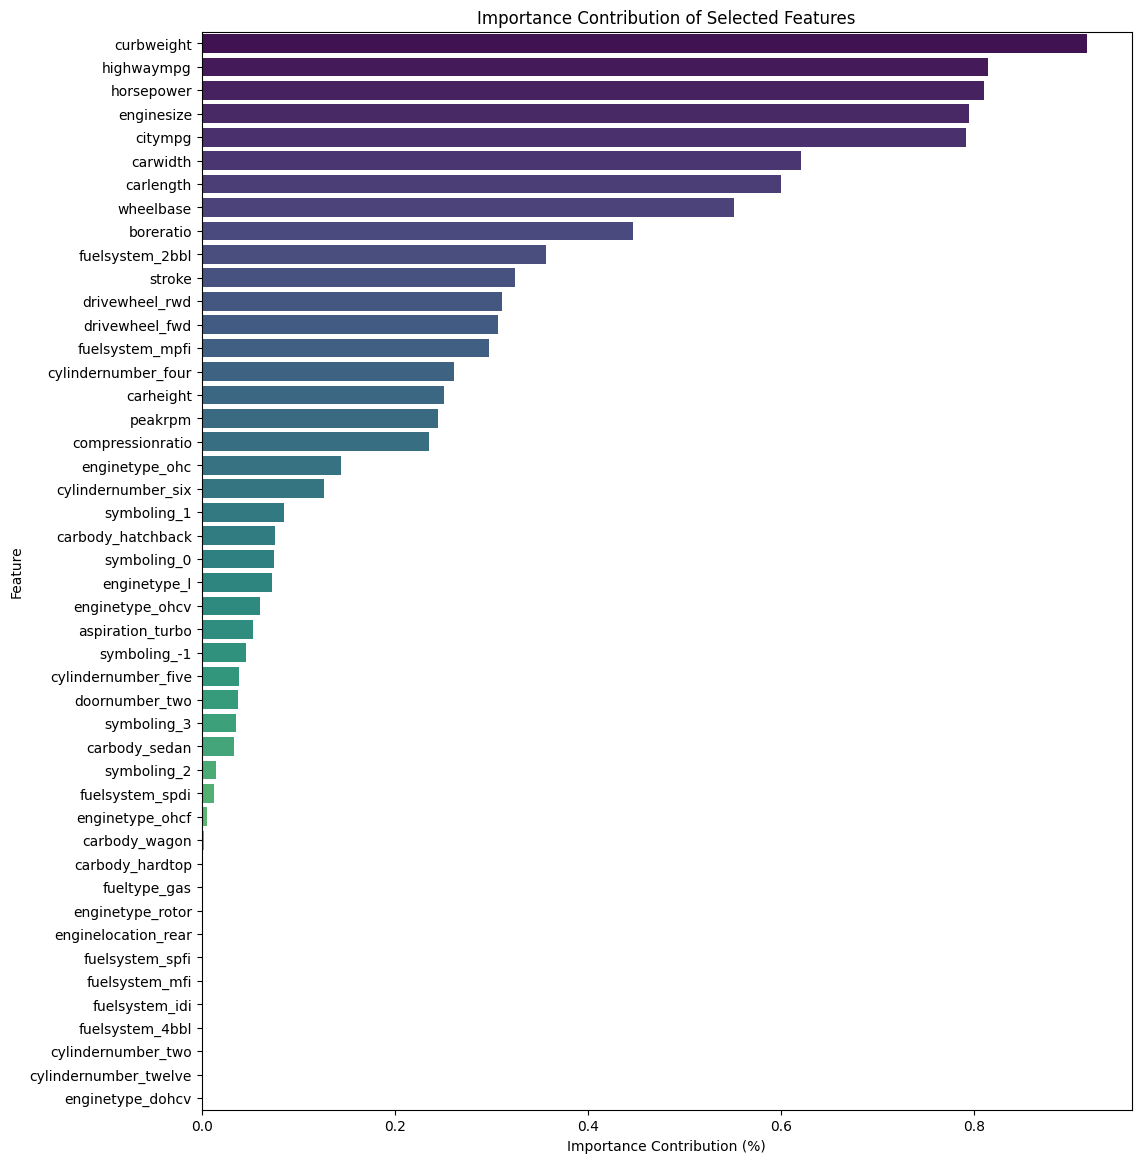

In [60]:
plot_features_importance(features_importance)


In [76]:
important_features = features_importance[features_importance['MI Score']>0.05]

In [77]:
important_features[['Feature', 'OneHot']] = important_features['Feature'].str.split('_', expand=True)

In [78]:
features_selected = list(important_features['Feature'].unique())

In [85]:
df = pd.read_csv('/kaggle/input/car-price-prediction/CarPrice_Assignment.csv')

In [86]:
features = features_selected
X_train, X_test, y_train, y_test = split_data_train_test(df, features, target_feature)

In [95]:
#preprocessing pipeline for model

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler, PowerTransformer, KBinsDiscretizer, StandardScaler
from sklearn.compose import ColumnTransformer
import scipy

nominal_pipeline = make_pipeline(OneHotEncoder(drop='first', handle_unknown = 'ignore'))
numeric_pipeline = make_pipeline(PowerTransformer('yeo-johnson'),MinMaxScaler())


numerical_features = [col for col in numerical_features if col in features_selected]
categorical_features = [col for col in categorical_features if col in features_selected]


preprocessing_pipeline = ColumnTransformer(transformers=[
    ('nominal_pipeline',nominal_pipeline,categorical_features),
    ('numeric_pipeline',numeric_pipeline,numerical_features)
])
preprocessing_pipeline

ColumnTransformer(transformers=[('nominal_pipeline',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['symboling', 'aspiration', 'carbody',
                                  'drivewheel', 'enginetype', 'cylindernumber',
                                  'fuelsystem']),
                                ('numeric_pipeline',
                                 Pipeline(steps=[('powertransformer',
                                                  PowerTransformer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['wheelbase', 'carlength', 'carwidth',
                                  'carheight', 'curbweight', 'enginesize',
                                  'boreratio', 'stroke', 'compressionratio',
                                  'horsepower', 'peakrpm', 'citympg',
                                  'highwaympg'])])

In [96]:
name = 'RF Regressor'
model = RandomForestRegressor()

In [107]:
pipelined_model = make_pipeline(preprocessing_pipeline,model)


In [ ]:
pipelined_model.fit(X_train, y_train)
y_pred = pipelined_model.predict(X_test)
results = evaluate_model(y_test, y_pred)

In [99]:
results

{'Mean Absolute Error': 1300.4109878048782,
 'Mean Squared Error': 3490489.7461982244,
 'Max Error': 5749.309999999998,
 'R^2': 0.9557852550794299,
 'Explained Variance': 0.9567335582009259}

# TODO: Hyperparameter Tuning

In [102]:
param_grid = {
    'randomforestregressor__n_estimators': [50, 100, 200],
    'randomforestregressor__max_depth': [None, 10, 20, 30],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [2, 4, 50],
    'randomforestregressor__bootstrap': [True, False]
}

In [112]:
pipeline = make_pipeline(preprocessing_pipeline,model)

In [122]:
import warnings
warnings.filterwarnings(action="ignore")

# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(estimator=pipelined_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
# grid_search.fit(X_train,y_train)


In [120]:
grid_search.best_params_

{'randomforestregressor__bootstrap': True,
 'randomforestregressor__max_depth': 30,
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 50}